# Error analysis

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Name of considered video:

In [419]:
video_name = "video_test_0000006"

Loading labels signification

In [420]:
file = open("class_list.txt","r")
labels_signification = []
s = file.readline()[2:-1]
while s != "":
    labels_signification.append(s)
    s = file.readline()[2:-1]

## Stage 1

In [421]:
video_ids_s1 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/no_crf/vid_eval_step_120000.csv", delimiter=",")
video_ids_s1 = video_ids_s1.astype(int)
labels_s1 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/no_crf/labels_eval_step_120000.csv", delimiter=",")

In [422]:
num_frames = np.max(video_ids_s1[:,1])
print("num_frames =", num_frames)

num_frames = 1983


In [423]:
mins=3
sec=15
target=4042
fps = num_frames/(mins*60 + sec)
print("{}:{}".format(int((target/fps)//60),int(target/fps)%60))

6:37


In [424]:
predictions_array_s1 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/no_crf/pred_eval_step_120000.csv", delimiter=",")

## Stage 2

In [425]:
video_ids_s2 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/semi_crf/vid_eval_step_120000.csv", delimiter=",")
video_ids_s2 = video_ids_s2.astype(int)
labels_s2 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/semi_crf/labels_eval_step_120000.csv", delimiter=",")

In [426]:
np.max(video_ids_s2[:,1]) == num_frames

True

In [427]:
predictions_array_s2 = np.loadtxt("/home/alex/Desktop/experiments/thumos/semi-crf/"+video_name+"/semi_crf/pred_eval_step_120000.csv", delimiter=",")

Mapping between 1st stage results and 2nd stage results:

In [428]:
idxes = [np.where(video_ids_s2[:,1] == video_ids_s1[i,1])[0][0] for i in range(num_frames+1)]

Reordering the 2nd stage results according to the 1st stage results'order:

In [429]:
video_ids_s2 = video_ids_s2[idxes]
predictions_array_s2 = predictions_array_s2[idxes]
labels_s2 = labels_s2[idxes]

## Comparing the different stages

Check ordering:

In [430]:
np.sum(labels_s1 == labels_s2) == (num_frames+1)*65

True

Random observation:

In [431]:
idx = 200
top_k = 5


print("Ground truth:")
print(np.where(labels_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth:")
print([labels_signification[i] for i in np.where(labels_s1[idx]>0)[0]])
print("Stage 1:")
print([labels_signification[i] for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]]) 
print("Stage 2:")
print([labels_signification[i] for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]]) 

Ground truth:
[31]
Stage 1:
[23 62 64 20 34]
Stage 2:
[23 62 42 20 25]

Ground truth:
[' FistPump']
Stage 1:
[' Stand', ' TalkToCamera', ' NoHuman', ' Walk', ' TwoRaisedArmCelebrate']
Stage 2:
[' Stand', ' TalkToCamera', ' BodyContract', ' Walk', ' Jump']


Metrics:

In [432]:
def ap(ground_truth, predictions, top_k=-1):
    numpos = np.size(np.where(ground_truth > 0))
    if numpos == 0:
        return 0
    delta_recall = 1.0 / numpos
    sortidx = sorted(range(len(predictions)),
                     key=lambda k: predictions[k],
                     reverse=True)
    n = len(sortidx)
    if top_k>0:
        n = top_k
    poscount = 0
    
    
    ap = 0
    for i in range(n):
        if ground_truth[sortidx[i]] > 0:
            poscount += 1
            ap += poscount / (i + 1) * delta_recall
    return ap

In [433]:
def gap(labels, predictions, top_k=-1):
    
    labels = labels.flatten()
    predictions = predictions.flatten()
    
    return ap(labels, predictions, top_k)

In [434]:
gap(labels_s1, predictions_array_s1)

0.6337597440166322

In [435]:
gap(labels_s2, predictions_array_s2)

0.5578975814625837

In [436]:
def map_calc(labels, predictions):
    aps = [ap(labels[:,q],predictions[:,q]) for q in range(labels.shape[1])]
    return np.mean(aps)

In [437]:
map_calc(labels_s1, predictions_array_s1)

0.09731589989666314

In [438]:
map_calc(labels_s2, predictions_array_s2)

0.09443873207199915

Individual performances for both stages:

In [439]:
perf_gap_1 = [gap(labels_s1[i], predictions_array_s1[i]) for i in range(len(labels_s1))]
perf_gap_2 = [gap(labels_s2[i], predictions_array_s2[i]) for i in range(len(labels_s2))]

Effect of the CRF on individual performances:

In [440]:
diff_gap_2_1 = [perf_gap_2[i] - perf_gap_1[i] for i in range(num_frames)]

In [441]:
mean(diff_gap_2_1)

-0.07422107920299612

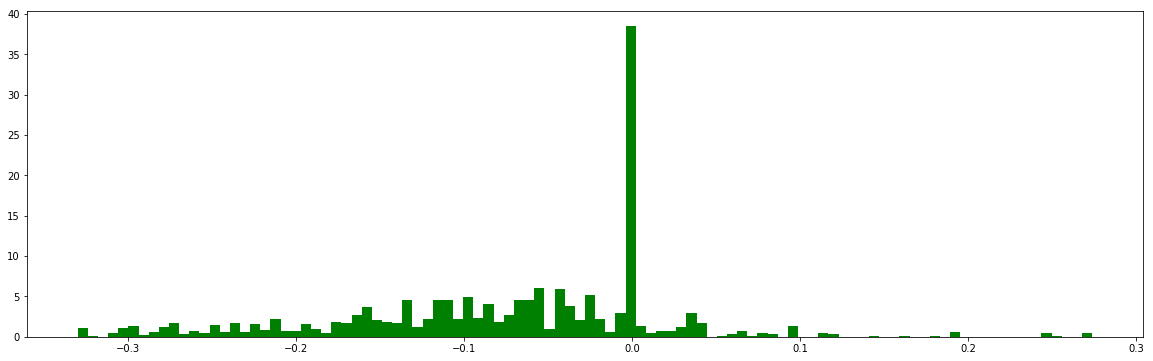

In [442]:
plt.figure(figsize=(20,6))
n, bins, patches = plt.hist(diff_gap_2_1, 100, normed=1, facecolor='green')

In [443]:
idxes_sorted = np.argsort(diff_gap_2_1)

In [448]:
idx = idxes_sorted[num_frames-19]
top_k = 5

print("Video name:")
print(video_name)

print("\nFrame id:")
frame_id = video_ids_s1[idx][1]+1
print(frame_id)


print("\nGAP difference:")
print(diff_gap_2_1[idx])

print("\nGround truth:")
print(np.where(labels_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth(s):")
for i in np.where(labels_s1[idx]>0)[0]:
    print("- " + labels_signification[i])
print("\nNo CRF:")
c = 0
for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]:
    print(str(c+1) + "." + labels_signification[i] + " - " + str(np.round(np.sort(predictions_array_s1[idx])[::-1][c],2)))
    c += 1

print("\nWith CRF:")
c = 0
for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]:
    print(str(c+1) + "." + labels_signification[i] + " - " + str(np.round(np.sort(predictions_array_s2[idx])[::-1][c],2)))
    c += 1

Video name:
video_test_0000006

Frame id:
1678

GAP difference:
0.1791666666666667

Ground truth:
[19 23 25 51]
Stage 1:
[23 24 25 19 21]
Stage 2:
[25 19 23 24 51]

Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump
-  VolleyballBlock

No CRF:
1. Stand - 0.78
2. Run - 0.72
3. Jump - 0.62
4. VolleyballSpiking - 0.55
5. Sit - 0.3

With CRF:
1. Jump - 0.85
2. VolleyballSpiking - 0.65
3. Stand - 0.61
4. Run - 0.34
5. VolleyballBlock - 0.16


In [446]:
for fr in range(1,51):
    print("\nfr=", fr)
    idx = idxes_sorted[num_frames-fr]

    print("Ground truth(s):")
    for i in np.where(labels_s1[idx]>0)[0]:
        print("- " + labels_signification[i])



fr= 1
Ground truth(s):
-  Stand
-  HighFive

fr= 2
Ground truth(s):
-  Stand
-  HighFive

fr= 3
Ground truth(s):
-  Stand
-  HighFive

fr= 4
Ground truth(s):
-  Stand
-  HighFive

fr= 5
Ground truth(s):
-  Stand
-  HighFive

fr= 6
Ground truth(s):
-  Stand
-  HighFive

fr= 7
Ground truth(s):
-  Stand
-  HighFive

fr= 8
Ground truth(s):
-  Stand
-  HighFive

fr= 9
Ground truth(s):
-  Stand
-  HighFive

fr= 10
Ground truth(s):
-  Stand
-  HighFive

fr= 11
Ground truth(s):
-  Stand
-  HighFive

fr= 12
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 13
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 14
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 15
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 16
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 17
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 18
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump

fr= 19
Ground truth(s):
-  VolleyballSpiking
-  Stand
-  Jump